# Keras tutorial

这一节学习使用Keras，一个高层次的深度学习编程框架。用Python写的，能在很多低级别的框架包括TensorFlow和CNTK上运行。

Keras开发是为了能够使深度学习工程师快速建立某实验的很多模型。能够从想法到结果以最少的延迟是找到好的模型的关键。然而，Keras与低级别的框架相比有更多的限制，所以有一些非常复杂的模型，可以实现在tensorflow但不（没有难度）Keras。也就是说，Keras将许多常用的模型精细。

In [24]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot_ng as pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## 1. Happy House
建立一个算法，使用门前面的相机拍到的照片来检查一个人是否快乐。门只给那些快乐的人打开。你现在已经拿到了一些图片关于你和朋友的照片，这些数据集已经被标记好了。
![快乐情感识别训练数据](https://upload-images.jianshu.io/upload_images/1779926-136af1fdffc9ebc8.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [25]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


## 2. 建立模型使用Keras
Keras是一个快速建立原型的工具。例子：
```python
def model(input_shape):
    # 定义输入样本的占位符，使用输入数据的维度，这就是你输入的图片
    X_input = Input(input_shape)

    # Zeros填充，pads表示对输入的数据的填充的像素
    X = ZeroPadding2D((3, 3))(X_input)

    # 对输入X应用卷积层 -> 批量归一化 -> RELU激活函数
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # X平展开，转化成向量+使用全连接层 
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # 创建模型This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

注意Keras关于变量名字有不同的约定，尤其，不再是创建和分配一个新的变量在前向传播的每一步中，例如 X, Z1, A1, Z2, A2, etc。而是在不同层的计算中，每一行都是将新的值分到X中，换句话说，前向传播的每一步，都只是把最近的值写进同一个变量X中，仅仅只有X_input我们分开的，没有覆盖，因为需要它最后创造Keras模型实例。model = Model(inputs = X_input, ...)

In [26]:
# GRADED FUNCTION: HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')

    
    ### END CODE HERE ###
    
    return model

现在已经实现了创建模型的函数，为了训练以及测试这个模型，接下来需要做四个步骤：
1. 创建模型并且调用上面的函数
2. 编译这个模型通过调用model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])
3. 训练这个模型在训练数据上，通过调用model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)
4. 测试这个模型使用测试数据，通过调用 model.evaluate(x = ..., y = ...)

关于Keras的官方文档:https://keras.io/models/model/

In [27]:
#实现步骤1 创建模型
### START CODE HERE ### (1 line)
happyModel = HappyModel(X_train.shape[1:])
### END CODE HERE ###

In [28]:
#实现步骤2 编译模型进入学习过程，注意这个模型是一个二分分类问题
### START CODE HERE ### (1 line)
happyModel.compile(optimizer='adam',loss='binary_crossentropy',metrics=["accuracy"])
### END CODE HERE ###

In [29]:
# 实现步骤3 训练这个模型，选择迭代次数和批的大小
### START CODE HERE ### (1 line)
happyModel.fit(x=X_train, y=Y_train, epochs = 40, batch_size = 16)
### END CODE HERE ###

Epoch 1/40
600/600 [==============================] - 1s 2ms/step - loss: 1.1717 - acc: 0.6633
Epoch 2/40
600/600 [==============================] - 1s 2ms/step - loss: 0.2489 - acc: 0.9050
Epoch 3/40
600/600 [==============================] - 1s 1ms/step - loss: 0.1627 - acc: 0.9383
Epoch 4/40
600/600 [==============================] - 1s 1ms/step - loss: 0.1266 - acc: 0.9483
Epoch 5/40
600/600 [==============================] - 1s 1ms/step - loss: 0.0993 - acc: 0.9650
Epoch 6/40
600/600 [==============================] - 1s 1ms/step - loss: 0.0865 - acc: 0.9617
Epoch 7/40
600/600 [==============================] - 1s 1ms/step - loss: 0.1342 - acc: 0.9467
Epoch 8/40
600/600 [==============================] - 1s 1ms/step - loss: 0.0711 - acc: 0.9767
Epoch 9/40
600/600 [==============================] - 1s 1ms/step - loss: 0.0600 - acc: 0.9750
Epoch 10/40
600/600 [==============================] - 1s 1ms/step - loss: 0.0580 - acc: 0.9783
Epoch 11/40
600/600 [============================

如果你继续fit的话，这个模型会继续用刚才训练好的参数，因为已经把训练好的参数去重新初始化了最开始的参数。

In [30]:
#实现第4步，评估模型
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(x = X_test, y = Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 1ms/step

Loss = 0.07171078542868296
Test Accuracy = 0.9733333396911621


## 3. 总结
对于Kears工具，我们并不能知道其中的细节到底做了什么工作。

从这一节我们学到什么：
1. Kears是一个工具，推荐用来快速建立原型并且迭代，选择最适合的原型。它允许很快的尝试不同的模型架构。
2. 记住如何使用Keras实现一个模型以及把你的模型使用到你的测试集上的四个步骤。
Create->Compile->fit/train->evaluate/test

## 4. 使用自己的图片进行测试
另外两个你可能用到的函数：
- `model.summary()`: 打印每一层的细节表，关于每一层输出和输出的大小
- `plot_model()`: 画图. You can even save it as ".png" using SVG() if you'd like to share it on social media ;). It is saved in "File" then "Open..." in the upper bar of the notebook.

[[0.]]


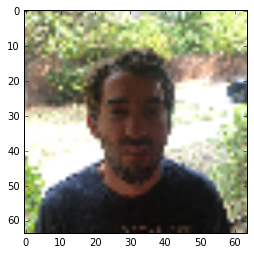

In [31]:
### START CODE HERE ###
img_path = 'images/my_image.jpg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

[[0.]]


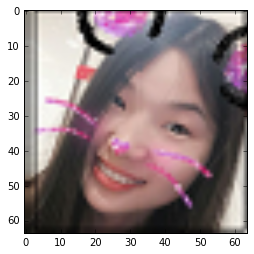

In [32]:
### START CODE HERE ###
img_path = 'images/me.png'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

关于测试，最开始我使用的是手机拍的照片，像素特别的大，直接传入测出来结果不正确，之后我将照片进行裁剪，成大概50\*50像素，再次运行，检测结果就正确了。说明有时候测试数据如果跟训练数据分布相差太大，有可能使得测试结果没那么准确。

In [33]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
__________

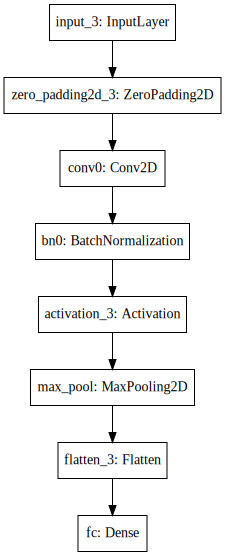

In [34]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))
#这里应该画出结构图，并且在目录文件夹中有HappyModel.png生成。

这里遇到了一个问题，因为之前没有使用过pydot这个包，在pip里面简单的安装了，代码报错，报错内容是需要安装pydot和graphviz，原来graphviz也是另一个包，并且这个包的安装在Windows下不能直接安装，需要去下面网址去下载graphviz-2.38.msi，然后进行安装，最后还要讲安装目录下的bin目录添加到path环境变量里面去，亲测如果不安装仍然会报错。两个包之间相互依赖，直接使用pip install pydot安装的包还是有问题，貌似是因为版本太新的问题，也尝试安旧版本，报错，后来找到更简单的解决办法，使用pip install pydot_ug,使用的时候修改，使用import pydot_ug as pydot，就解决问题啦。
1. pip install pydot_ug 使用时候import pydot_ug as pydot
2. 下载graphviz-2.38.msi并且添加环境变量：https://graphviz.gitlab.io/_pages/Download/Download_windows.html

想要测试两个包之间的关系以及是否安装好了，就用下面两行代码进行测试：
```python
import pydot_ng as pydot
print (pydot.find_graphviz())
```